In [ ]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [42]:
#Store the data into the df variable
SYMBOL = 'ETH'
df = pd.read_csv(f'../../data/{SYMBOL}.csv')

In [43]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)
#Show the dataframe
# df

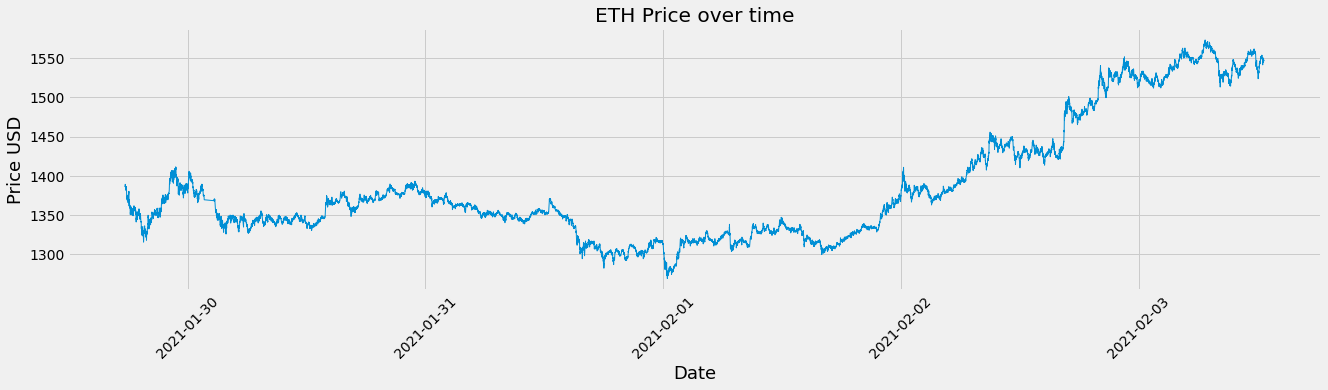

In [44]:
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.title(f"{SYMBOL} Price over time")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD',fontsize=18)
plt.show()

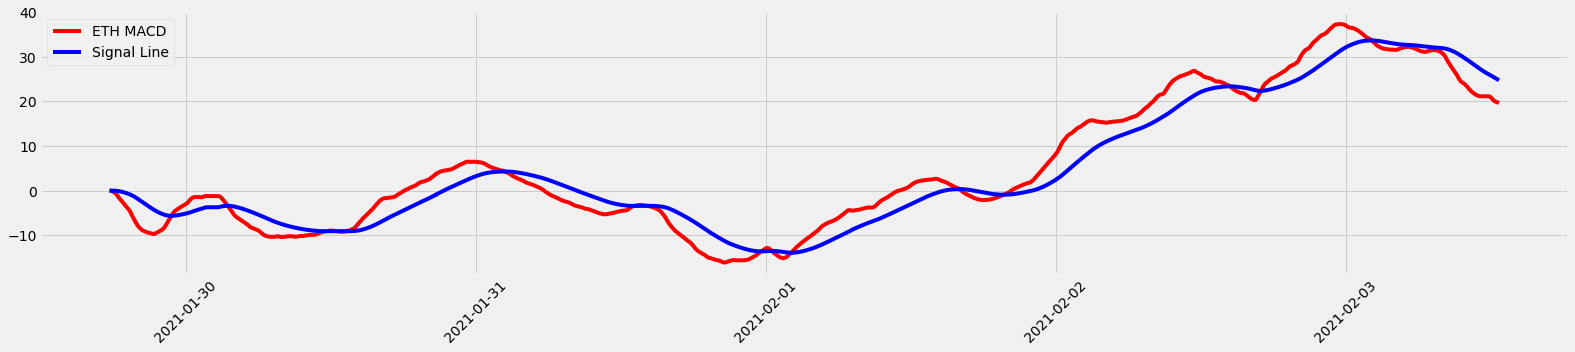

In [45]:

def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 16
# Best Multipliers for coins:
# ----------------------------
# ETH: 175, 178, 16
# BCH: 50, 692
# LTC: none
smoothed_df = df.price.ewm(span=20, adjust=False).mean() #AKA Slow moving average
macd, signal = createMacdAndSignalLines(smoothed_df, macd_params, macd_multiplier)




plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label=f"{SYMBOL} MACD", color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
# for i in range(len(df)):
#     if np.sign(macd[i] - signal[i]) != np.sign(macd[i-1] - signal[i-1]):
#         plt.annotate(str(f"{df.price[i]:.0f}"), (df.index[i], macd[i]+.5))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [46]:
df['MACD'] = macd
df['Signal Line'] = signal

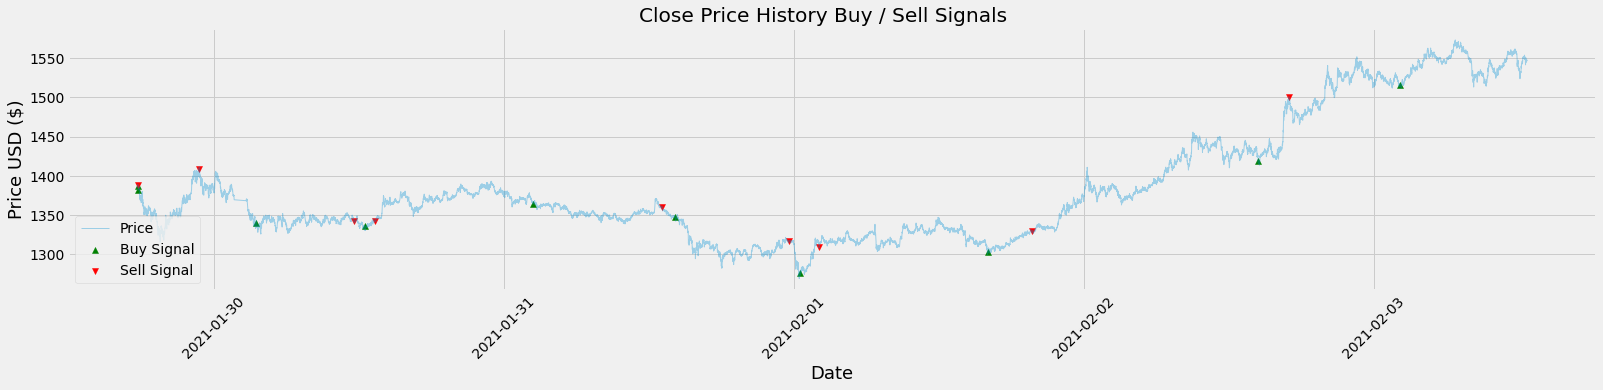

2021-01-29T17:41:30Z Bought at 1386.895  selling at 1392.39 for profit: 3.4950000000001182
2021-01-29T22:47:00Z Bought at 1385.685  selling at 1409.91491 for profit: 22.229910000000018
2021-01-30T11:33:15Z Bought at 1340.01  selling at 1346.385 for profit: 4.375
2021-01-30T13:17:00Z Bought at 1331.755  selling at 1346.75 for profit: 12.99499999999989
2021-01-31T13:04:15Z Bought at 1364.095  selling at 1356.655 for profit: -9.440000000000055
2021-01-31T23:36:15Z Bought at 1348.15  selling at 1313.365 for profit: -36.78500000000008
2021-02-01T02:03:30Z Bought at 1278.825  selling at 1311.025 for profit: 30.200000000000045
2021-02-01T19:40:00Z Bought at 1302.505  selling at 1329.76 for profit: 25.25499999999988
2021-02-02T16:56:45Z Bought at 1414.28  selling at 1495.095 for profit: 78.81500000000005
Profit 140.13990999999987
Transactions:  9


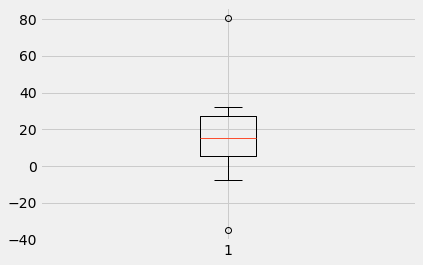

In [47]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        elif ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] < signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] > signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35, linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("Transactions: ", len(r[1]))
plt.boxplot(r[1])
plt.show()

In [48]:
# Find optimal period value:
run_cell = False

if run_cell:
    results = []
    for period_length in np.arange(2, 700, 2):
        macd_params = (12, 26, 9)
        macd_multiplier = period_length #was 111
        macd, signal = createMacdAndSignalLines(smoothed_df, macd_params, macd_multiplier)
        r = mac_daddy_tester(macd, signal, df, quiet=True)
        results.append((period_length, r[0], len(r[1])))
        # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))

    results.sort(key = lambda x: -x[1])
    for tup in results[:25]:
        print(f"Profit: ${tup[1]:.2f} Period Param: {tup[0]} Transactions: {tup[2]}")

KeyboardInterrupt: 